In [123]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import datetime
import numpy as np
from RandAugment import RandAugment
from sklearn.metrics import f1_score
from torcheval.metrics.functional import multiclass_f1_score
from torch import nn

from lightly.models import utils
from lightly.models.modules import masked_autoencoder
from lightly.transforms.mae_transform import MAETransform

import matplotlib.pyplot as plt

In [ ]:
#classes defition
classes_alias = {'tinto cao': 'TC', 'tinta francisca': 'TF', 'alicante': 'AC', 'alveralhao': 'AV', 'arinto': 'AT', 'bastardo': 'BT', 'boal': 'BA', 'cabernet franc': 'CF', 'cabernet sauvignon': 'CS', 'carignon noir': 'CN', 'cercial': 'CC', 'chardonnay': 'CD', 'codega': 'CG', 'codega do larinho': 'CR', 'cornifesto': 'CT', 'donzelinho': 'DZ', 'donzelinho branco': 'DB', 'donzelinho tinto': 'DT', 'esgana cao': 'EC', 'fernao pires': 'FP', 'folgasao': 'FG', 'gamay': 'GM', 'gouveio': 'GV', 'malvasia corada': 'MC', 'malvasia fina': 'MF', 'malvasia preta': 'MP', 'malvasia rei': 'MR', 'merlot': 'ML', 'moscatel galego': 'MG', 'moscatel galego roxo': 'MX', 'mourisco tinto': 'MT', 'pinot blanc': 'PB', 'rabigato': 'RB', 'rufete': 'RF', 'samarrinho': 'SM', 'sauvignon blanc': 'SB', 'sousao': 'SS', 'tinta amarela': 'TA', 'tinta barroca': 'TB', 'tinta femea': 'TM', 'tinta roriz': 'TR', 'touriga francesa': 'TS', 'touriga nacional': 'TN', 'viosinho': 'VO'}

In [158]:
#base_path = r'/mnt/c/Users/gabrielc'
base_path = r'/media/gabriel/BA1041B410417881/Users/gabrielc'
path_models = os.path.join(base_path, 'Projects', 'huge-classifier')
os.chdir(path_models)

base_dataset = r'/home/gabriel/'
main_path = os.path.join(base_dataset, 'Downloads', 'castas-huge2-split')


train_path = os.path.join(main_path, 'train')
#train_path = main_path
validation_path = os.path.join(main_path, 'validation')
#test_path = os.path.join(main_path, 'test')
test_path = r'/home/gabriel/Projects/iNaturalist/images-crops/'
#classes = os.listdir(train_path)


batch = 12 #the batch is small to multiply by the number of new generated images
size =  224
IMG_SIZE = (size, size)
epochs = 1000
warmup_epochs = 10
lr = 1.5e-4
comments = 'first test MAE'
path_mae = f'/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/huge-classifier/models/MAE_huge_classifier_weight_20230817-2004.pth'

In [159]:
transform = transforms.Compose([
    #transforms.RandAugment(num_ops=2, magnitude=8),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(0.5),
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    #RandAugment(n=3, m=10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_folder = datasets.ImageFolder(train_path, transform=transform, target_transform=lambda t: 0) # TODO: create the ImageFolder
train_ds = torch.utils.data.DataLoader(train_folder, batch_size=batch, shuffle=True) # TODO: use the ImageFolder dataset to create the DataLoader

test_folder = datasets.ImageFolder(test_path, transform=test_transform, target_transform=lambda t: 0) # TODO: create the ImageFolder
test_ds = torch.utils.data.DataLoader(test_folder, batch_size=batch, shuffle=False) # TODO: use the ImageFolder dataset to create the DataLoader

val_folder = datasets.ImageFolder(validation_path, transform=transform, target_transform=lambda t: 0) # TODO: create the ImageFolder
val_ds = torch.utils.data.DataLoader(val_folder, batch_size=batch, shuffle=False) # TODO: use the ImageFolder dataset to create the DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


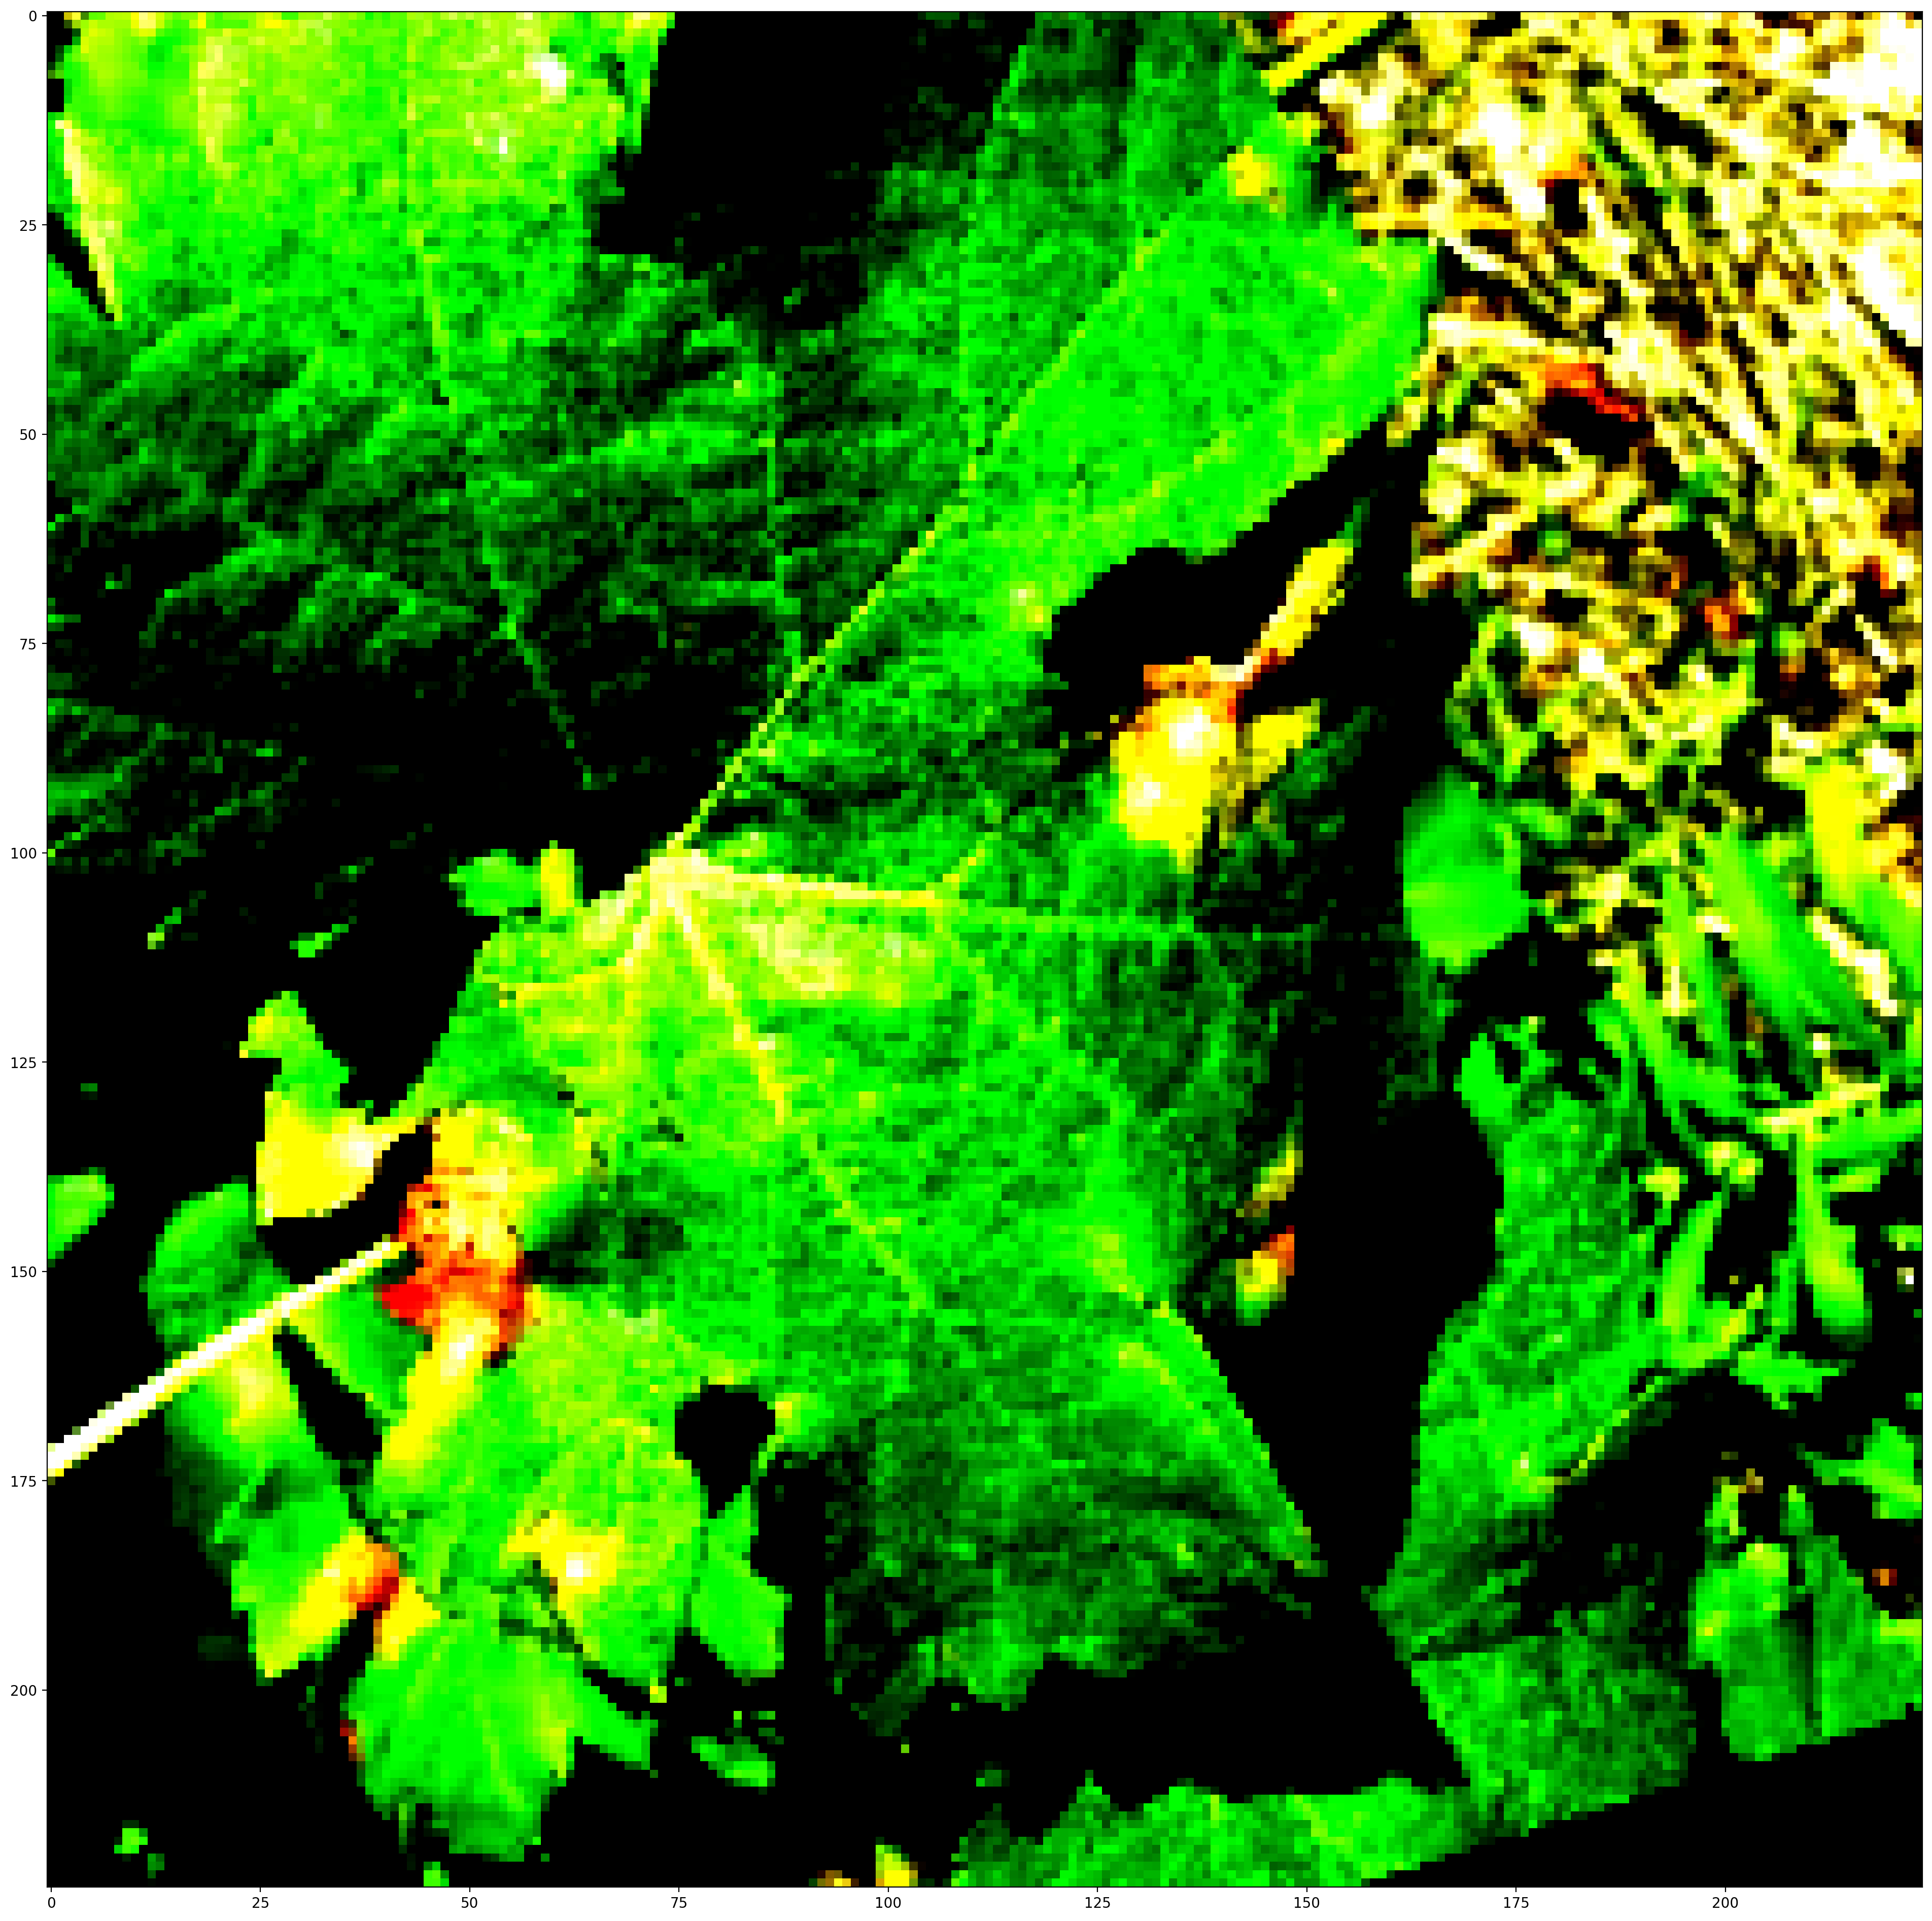

In [160]:
# Run this to test your data loader
images, labels = next(iter(train_ds))
plt.imshow(np.moveaxis(images[0].numpy(), 0, -1))


In [161]:
class MAE(nn.Module):
    def __init__(self, vit):
        super().__init__()

        decoder_dim = 512
        #starting the first test with 60% that was the best result in the orignial paper
        self.mask_ratio = 0.60
        self.patch_size = vit.patch_size
        self.sequence_length = vit.seq_length
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        self.backbone = masked_autoencoder.MAEBackbone.from_vit(vit)
        self.decoder = masked_autoencoder.MAEDecoder(
            seq_length=vit.seq_length,
            num_layers=1,
            num_heads=16,
            embed_input_dim=vit.hidden_dim,
            hidden_dim=decoder_dim,
            mlp_dim=decoder_dim * 4,
            out_dim=vit.patch_size**2 * 3,
            dropout=0.,
            attention_dropout=0.,
        )

    def forward_encoder(self, images, idx_keep=None):
        return self.backbone.encode(images, idx_keep)

    def forward_decoder(self, x_encoded, idx_keep, idx_mask):
        # build decoder input
        batch_size = x_encoded.shape[0]

        x_decode = self.decoder.embed(x_encoded)
        
        x_masked = utils.repeat_token(
            self.mask_token, (batch_size, self.sequence_length)
        )
        
        print(x_masked.size())
        x_masked = utils.set_at_index(x_masked, idx_keep, x_decode.type_as(x_masked))

        
        # decoder forward pass
        x_decoded = self.decoder.decode(x_masked)

        # predict pixel values for masked tokens
        x_pred = utils.get_at_index(x_decoded, idx_mask)
        x_pred = self.decoder.predict(x_pred)
        return x_pred

    def forward(self, images):
        batch_size = images.shape[0]

        #define the patches which will be hidden
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length),
            mask_ratio=self.mask_ratio,
            device=images.device,
        )

        #pass to the encoder
        x_encoded = self.forward_encoder(images, idx_keep)
        x_pred = self.forward_decoder(x_encoded, idx_keep, idx_mask)
        

        # get image patches for masked tokens
        patches = utils.patchify(images, self.patch_size)
        
        # must adjust idx_mask for missing class token
        target = utils.get_at_index(patches, idx_mask - 1)

        
        return x_pred, target, idx_keep, idx_mask

In [162]:
#implementation of https://github.com/facebookresearch/mae/blob/main/models_mae.py#L109
def unpatchify(x, p):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    image = torch.einsum('chw->hwc', image)
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

torch.Size([12, 197, 512])
torch.Size([12, 3, 224, 224])


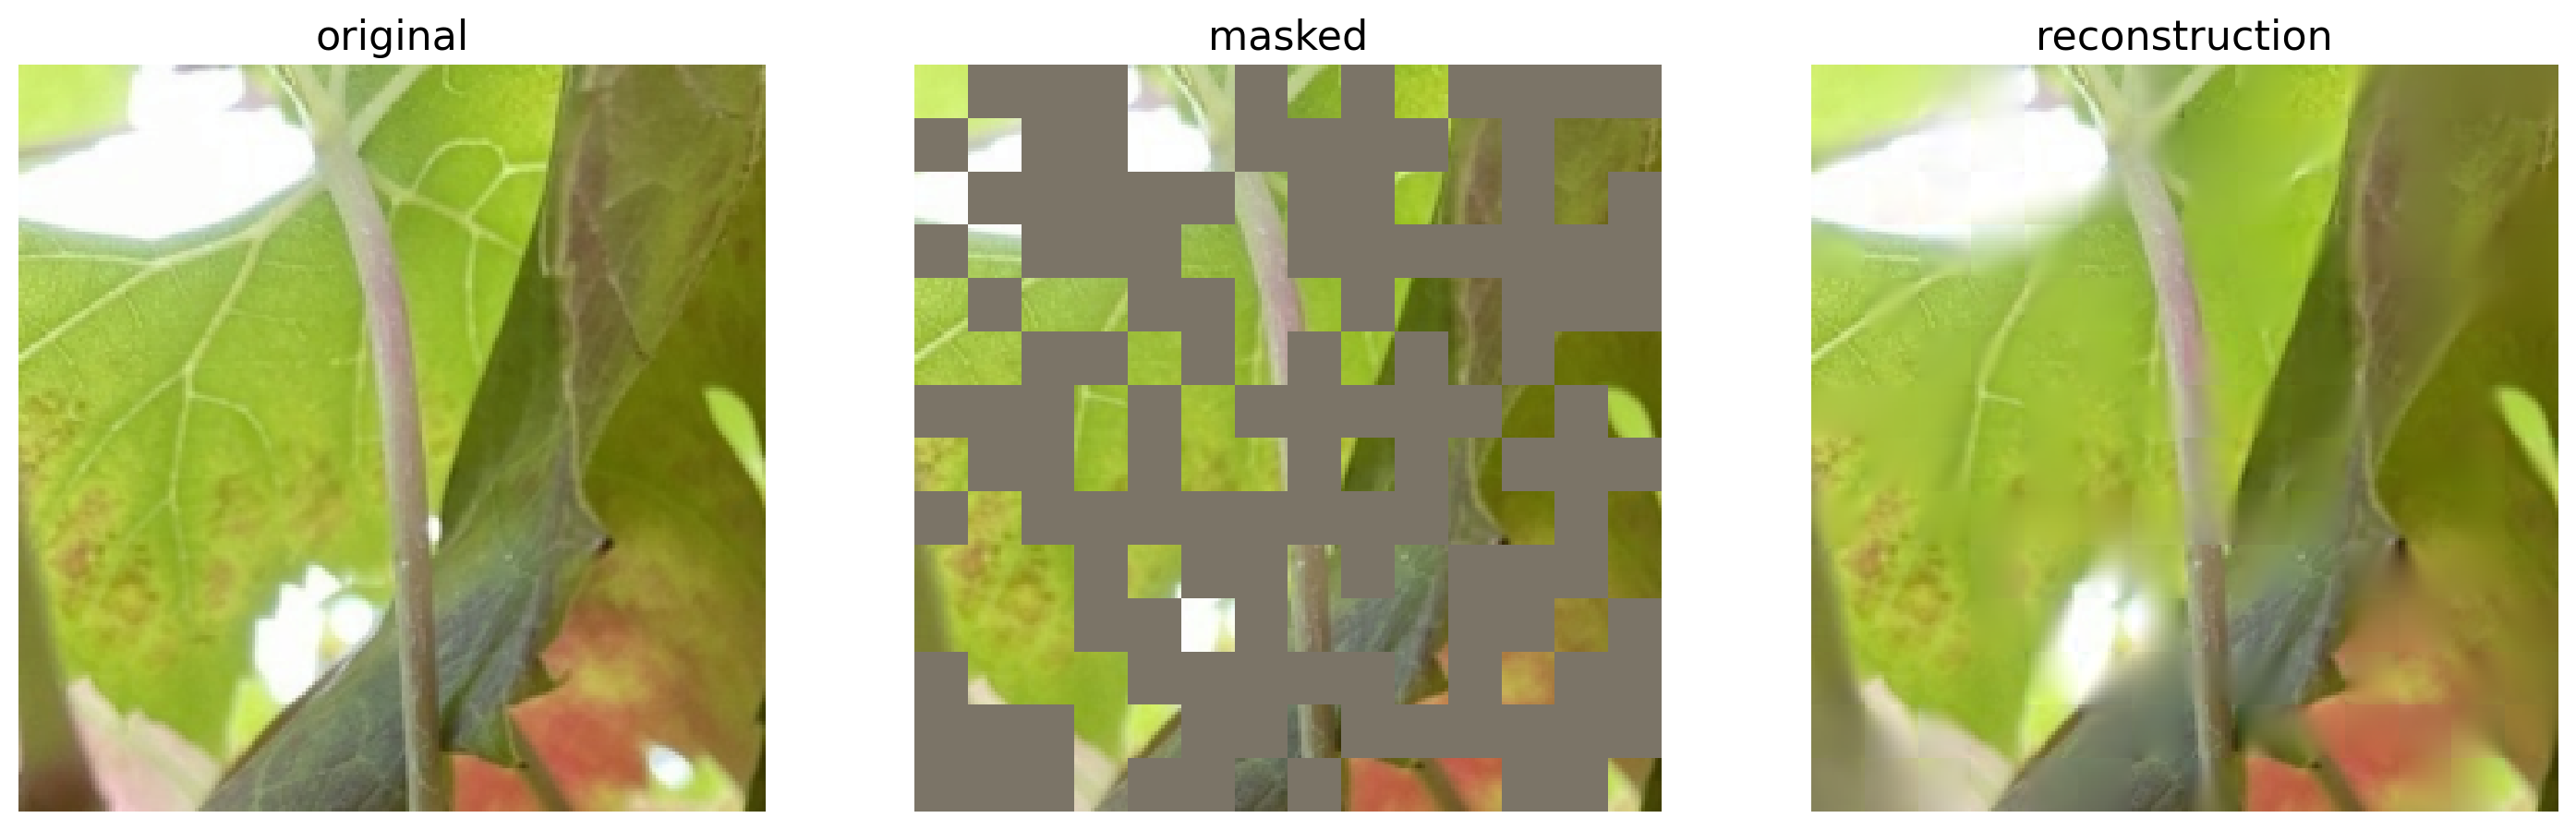

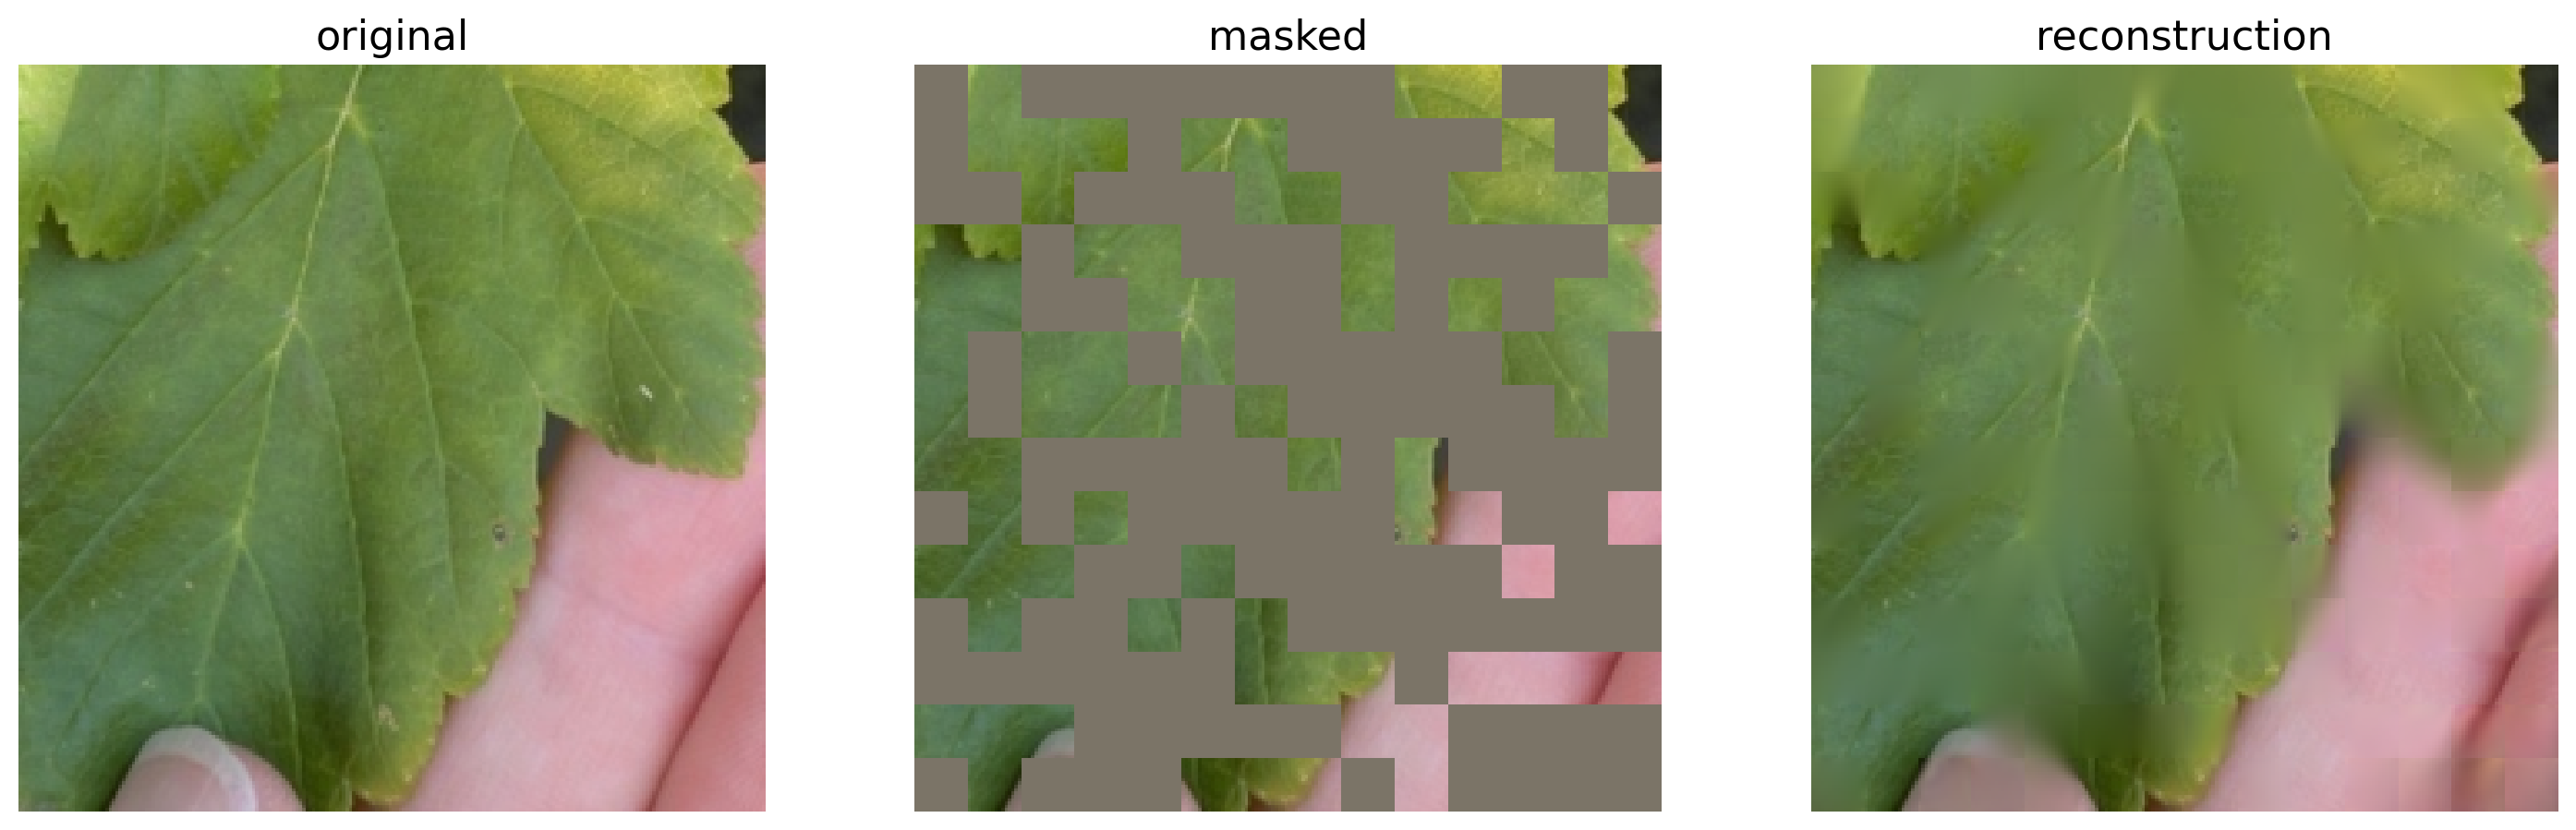

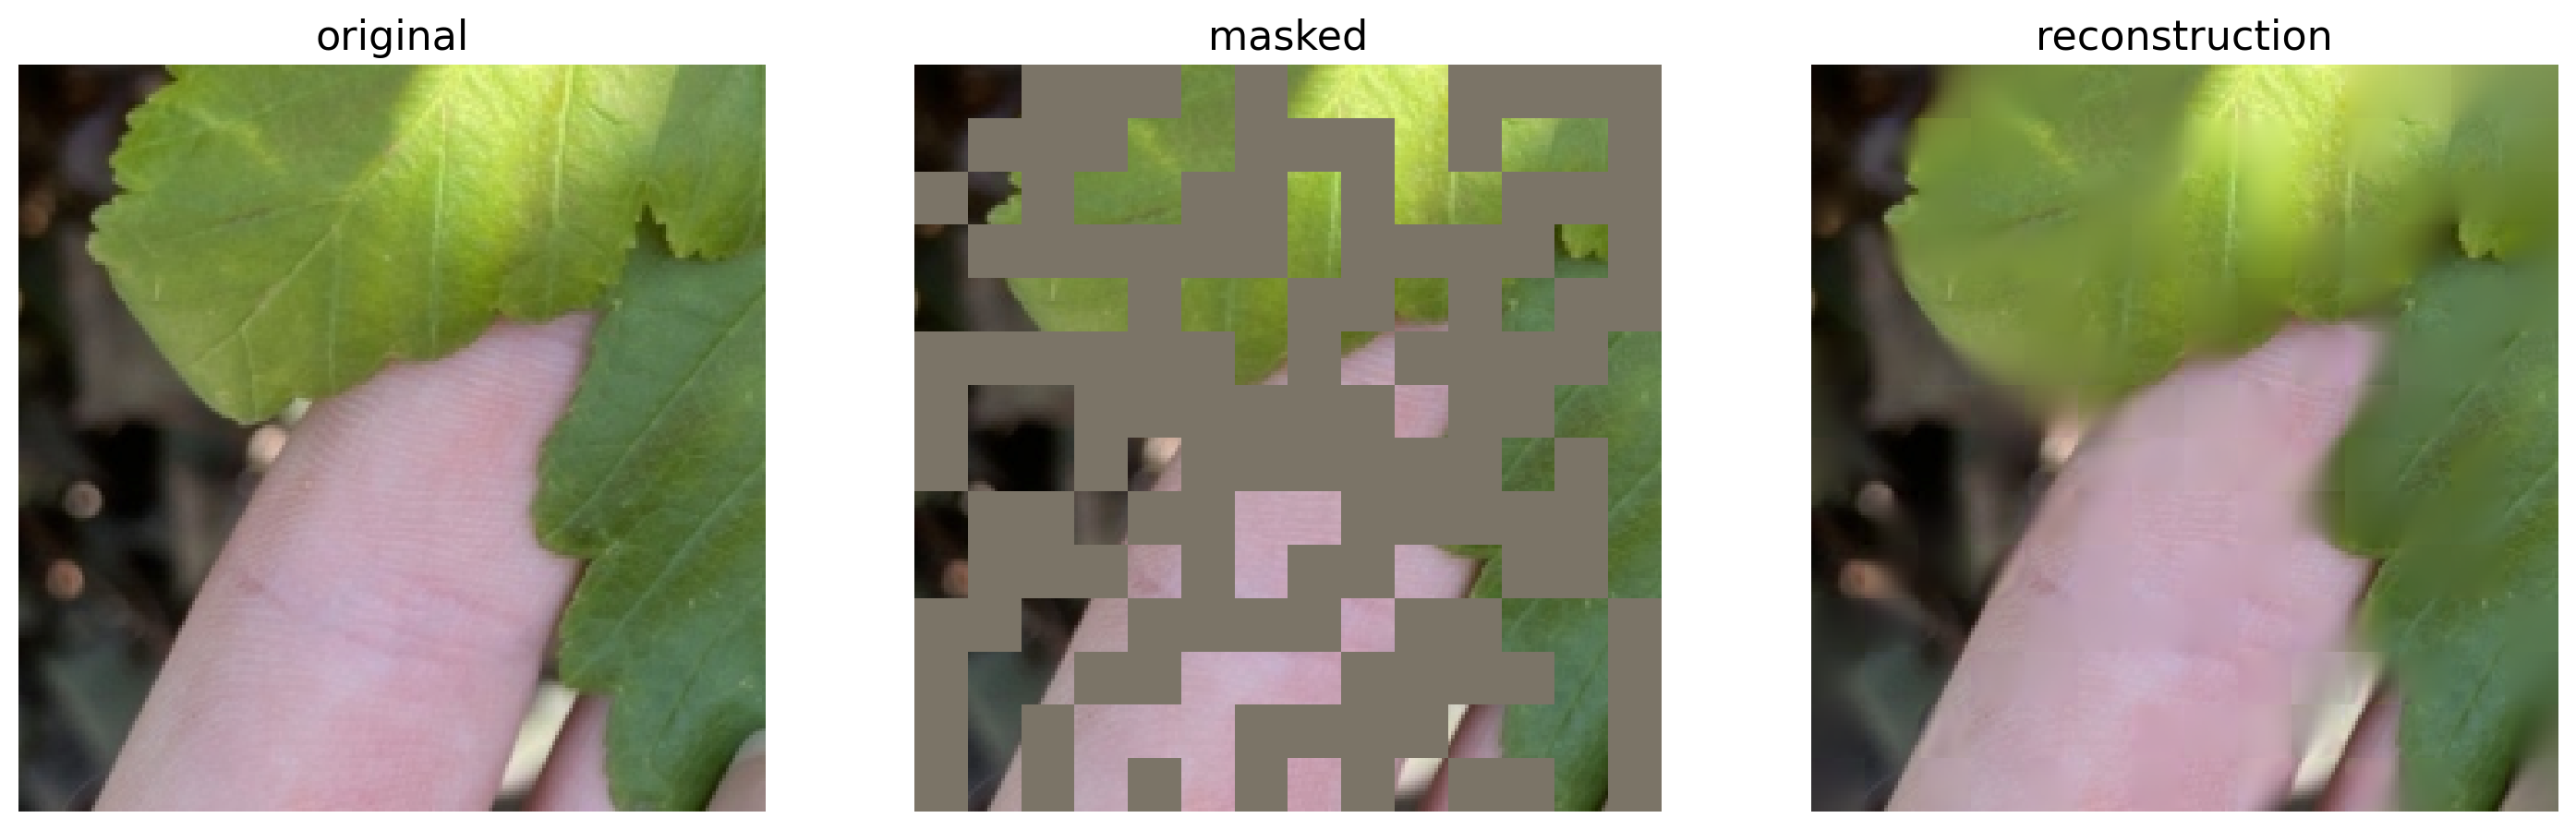

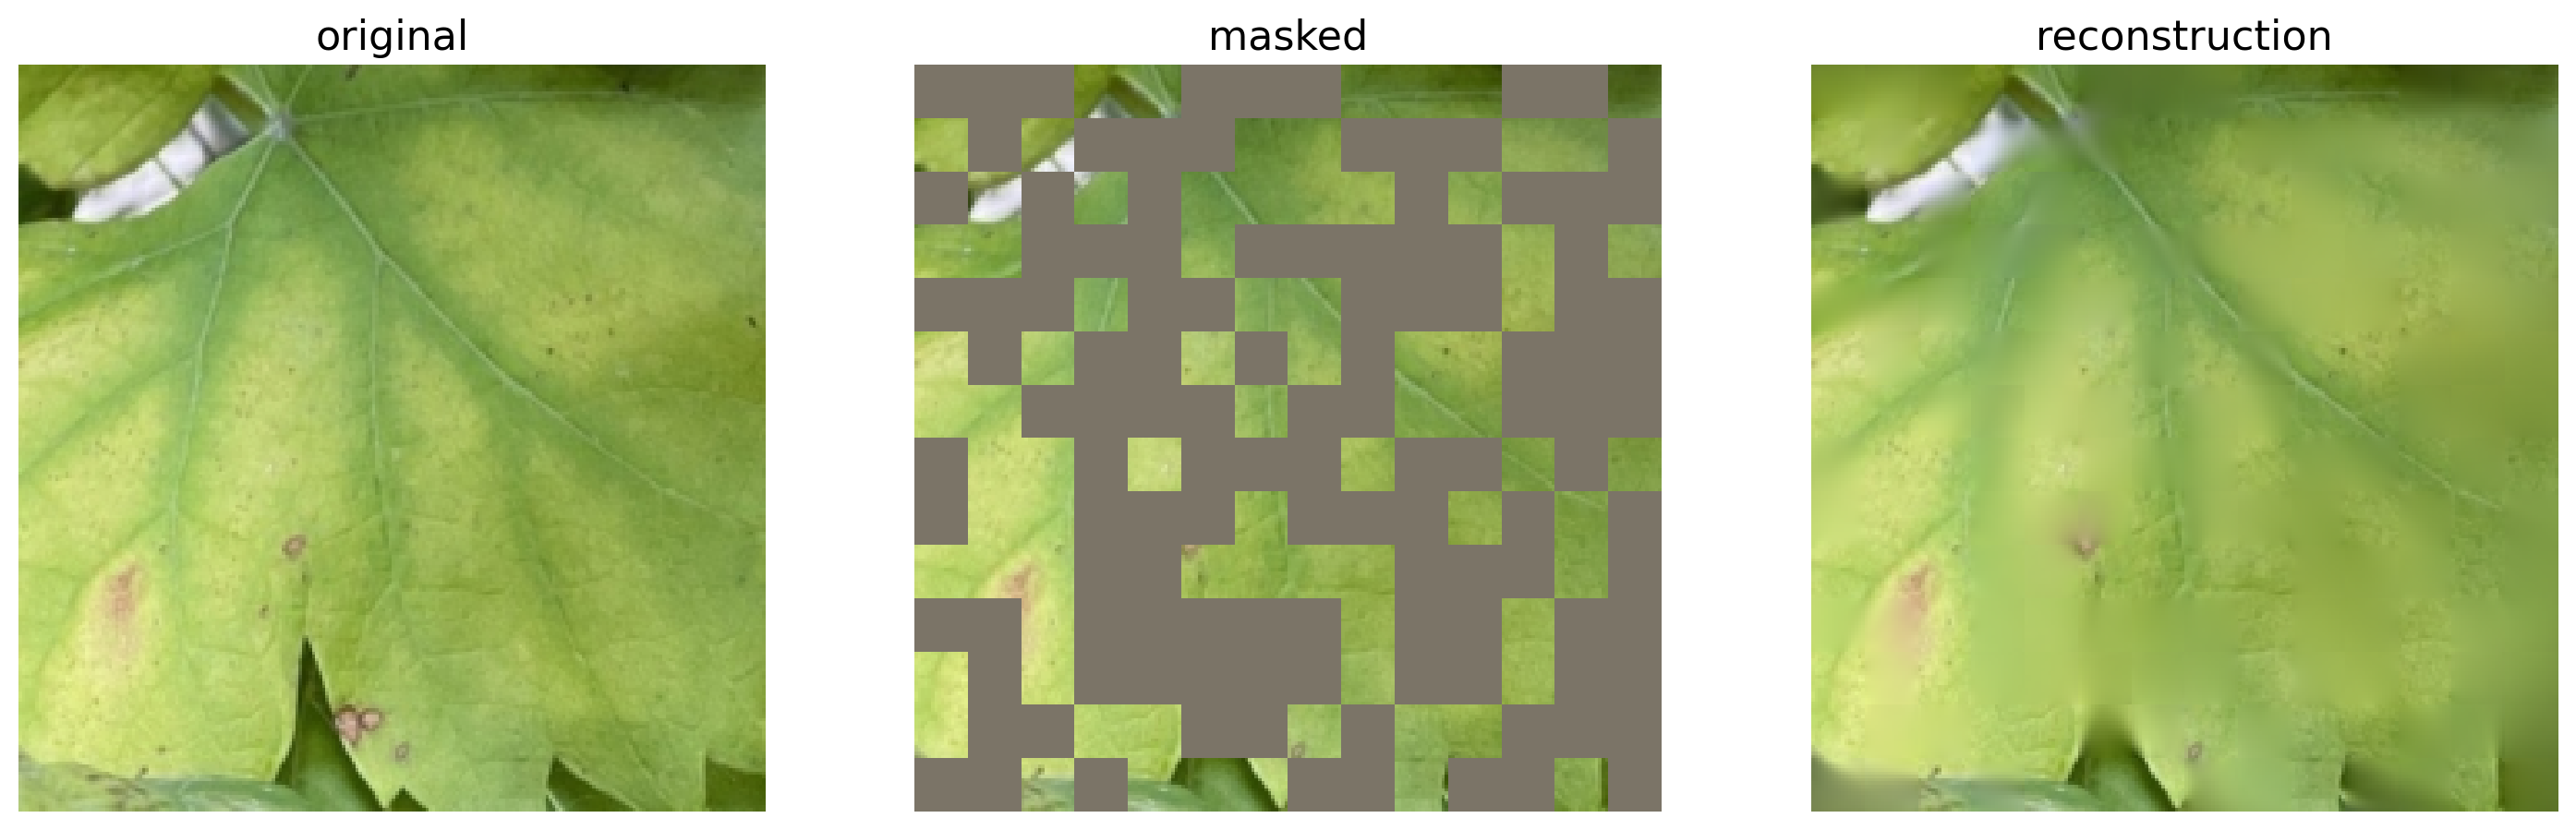

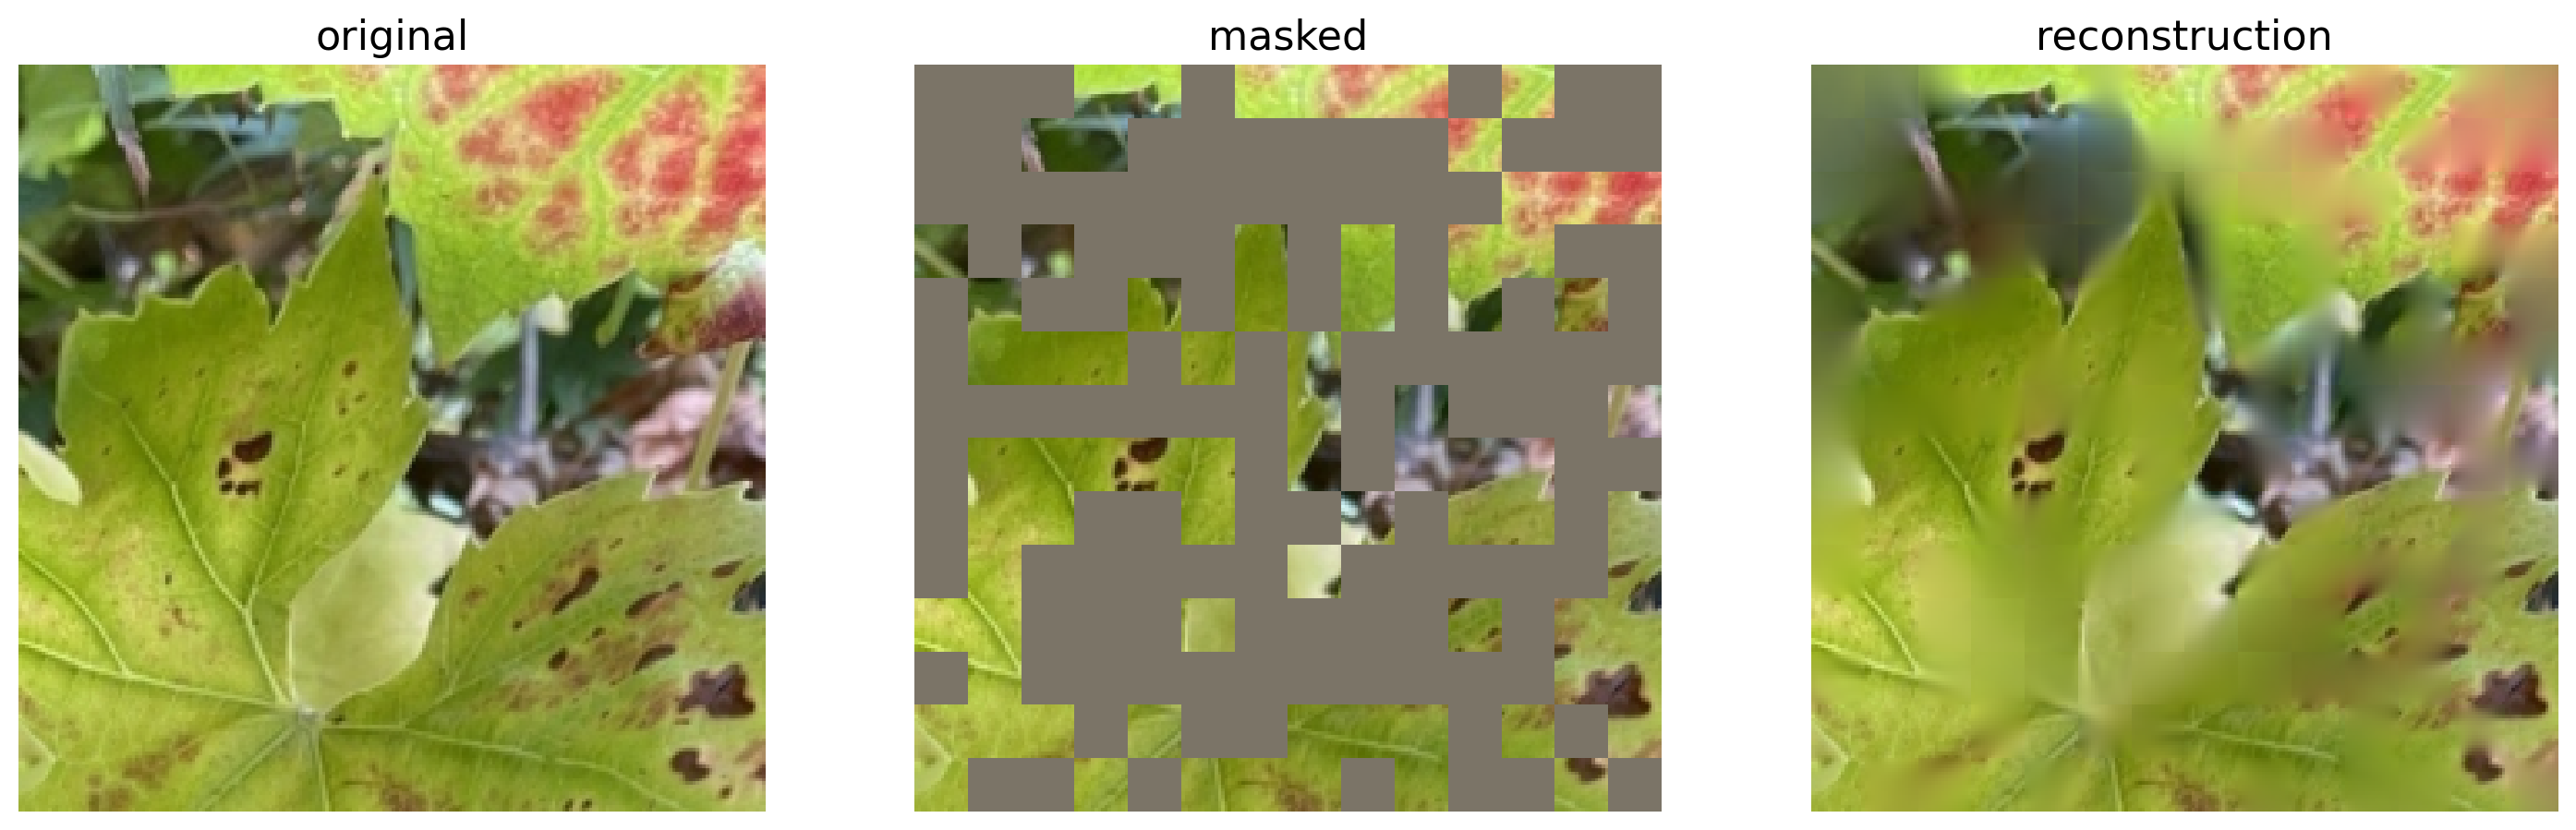

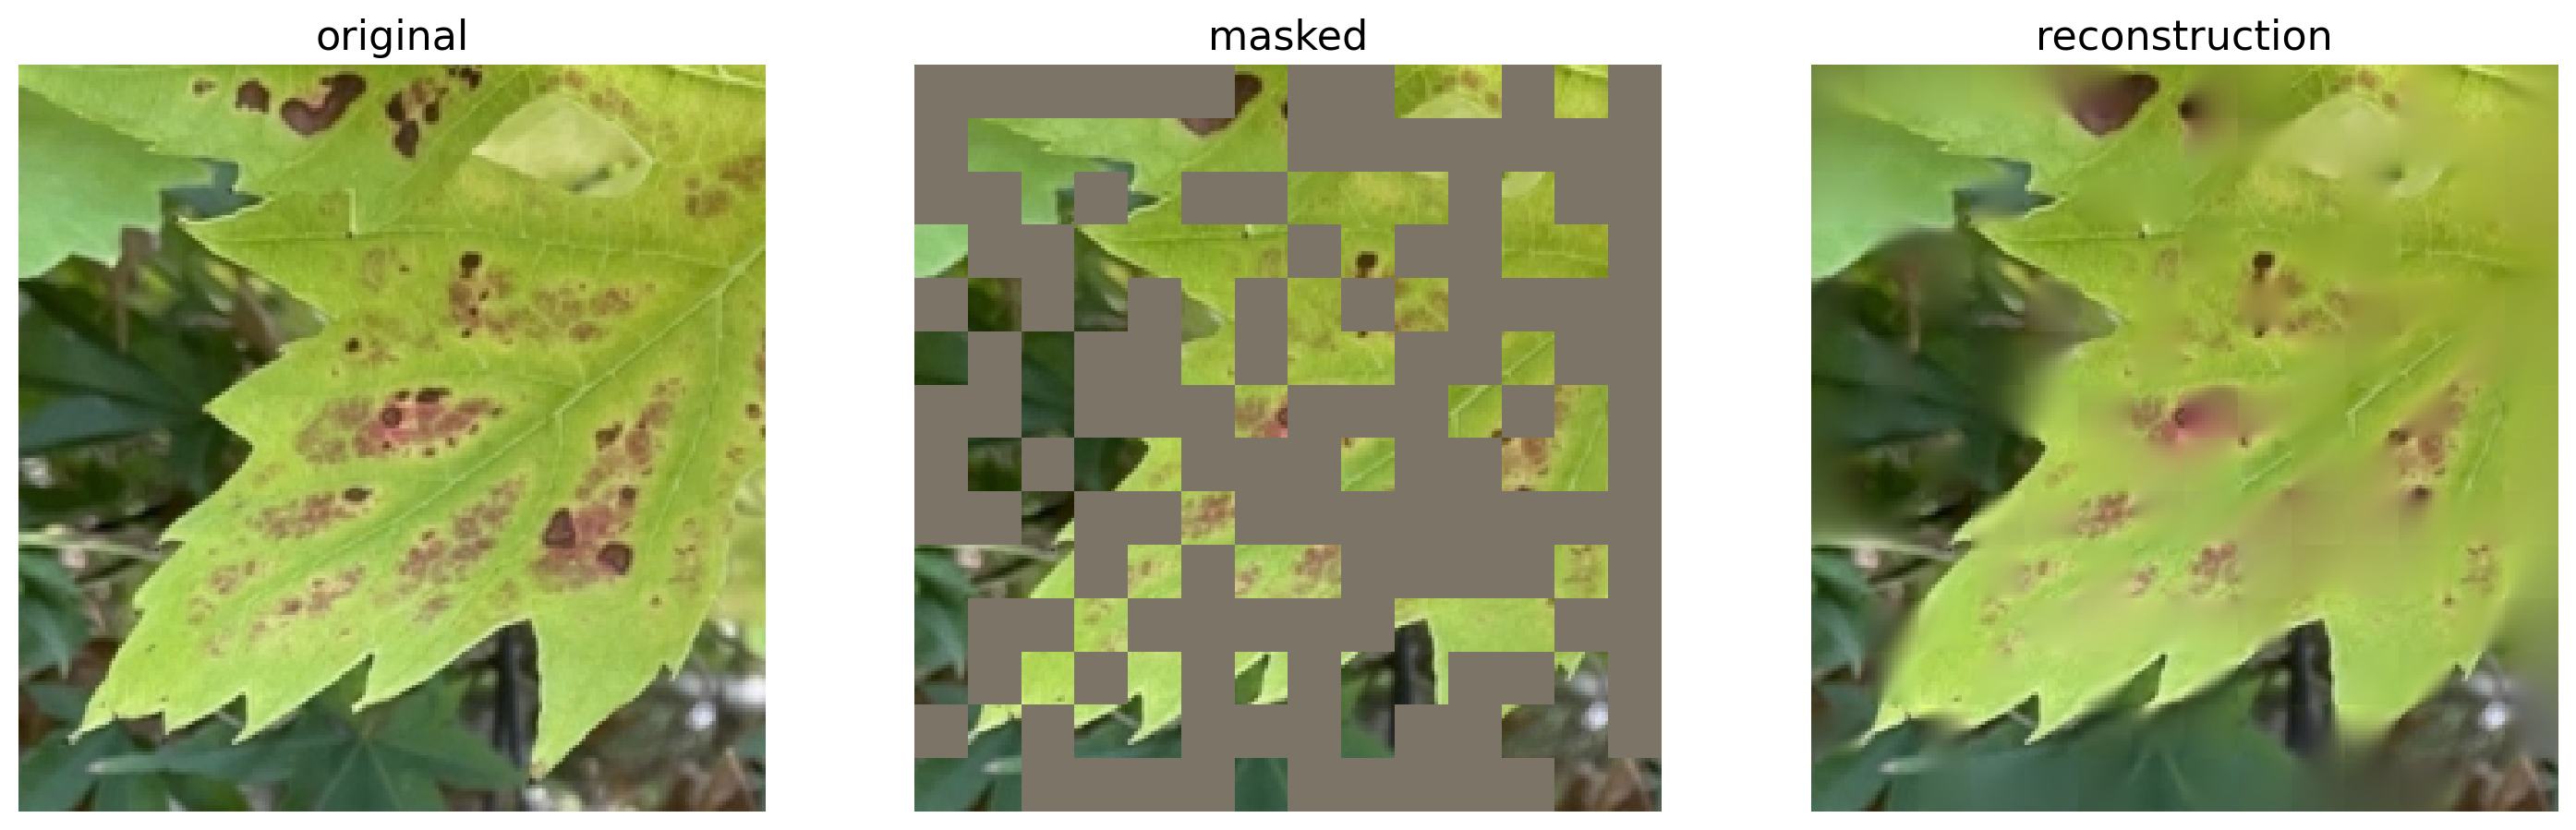

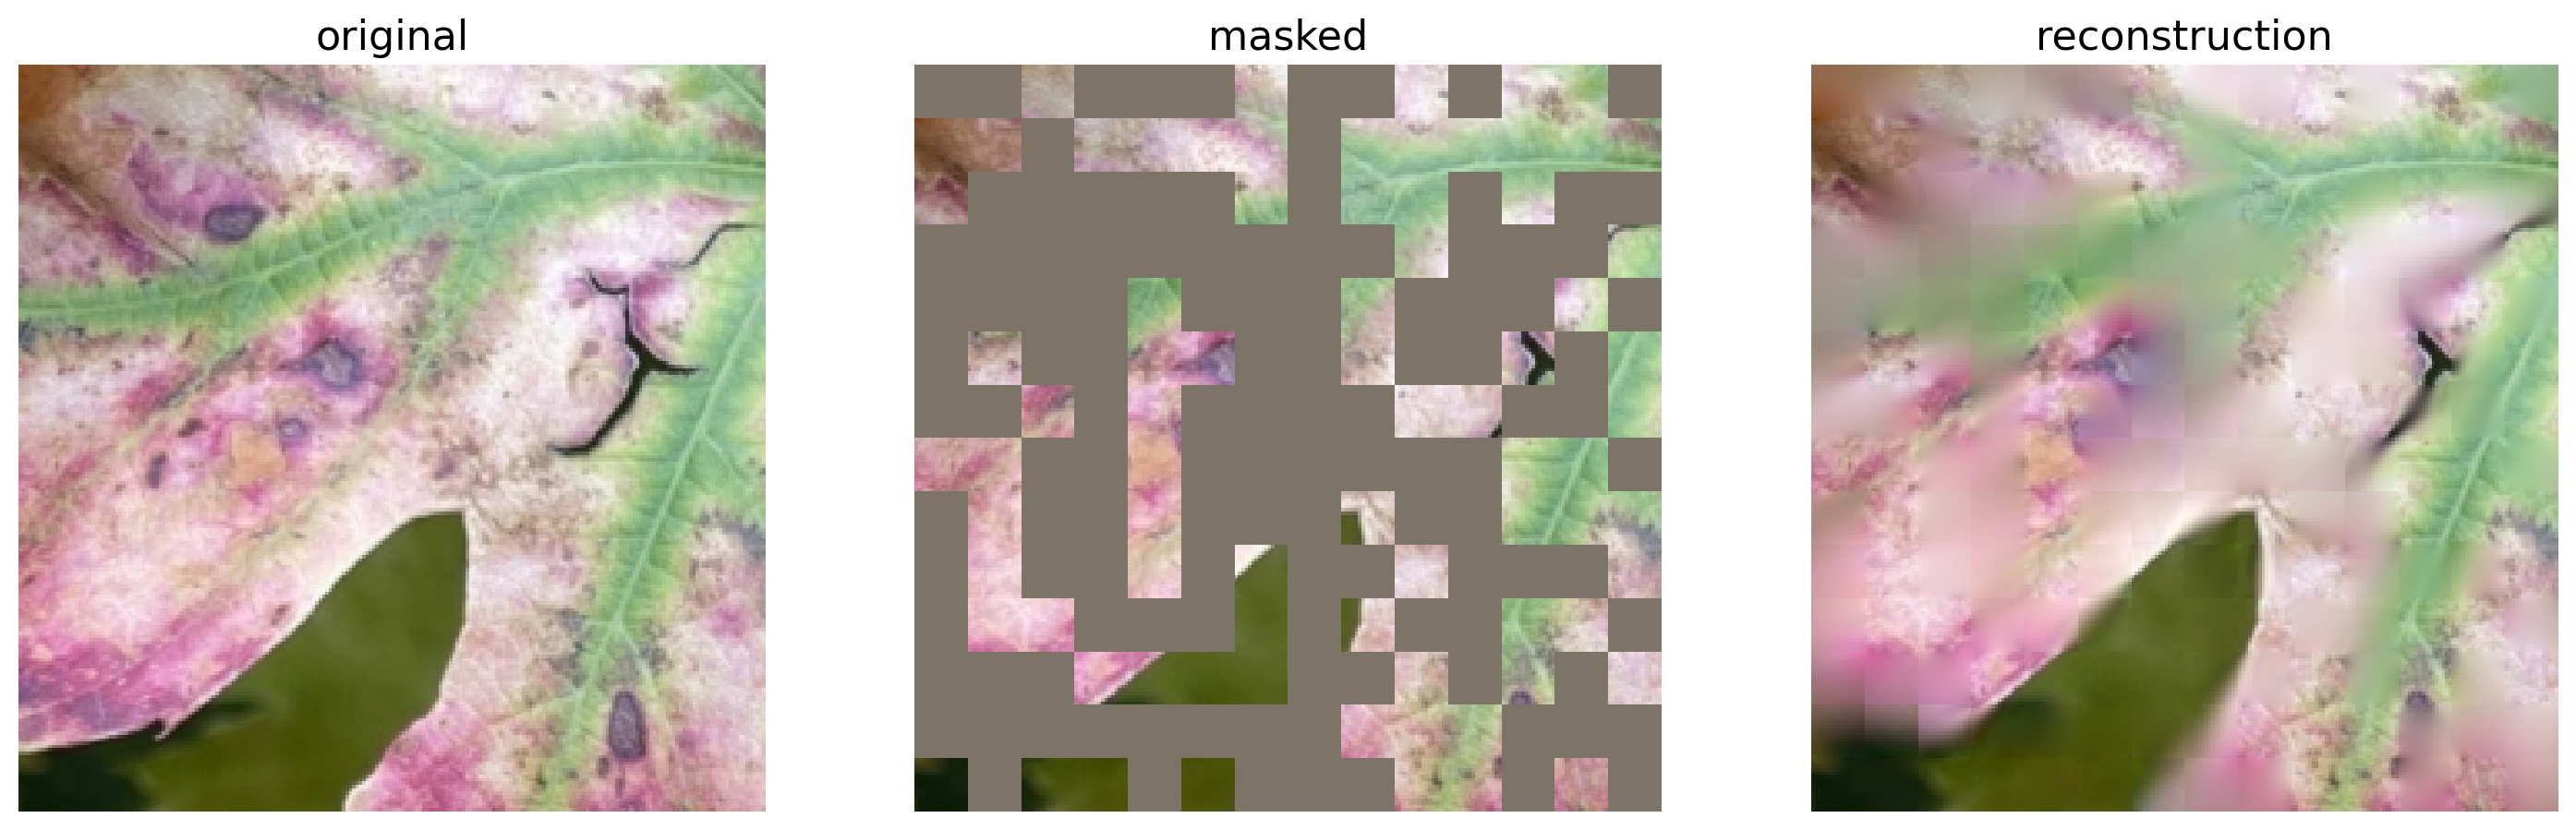

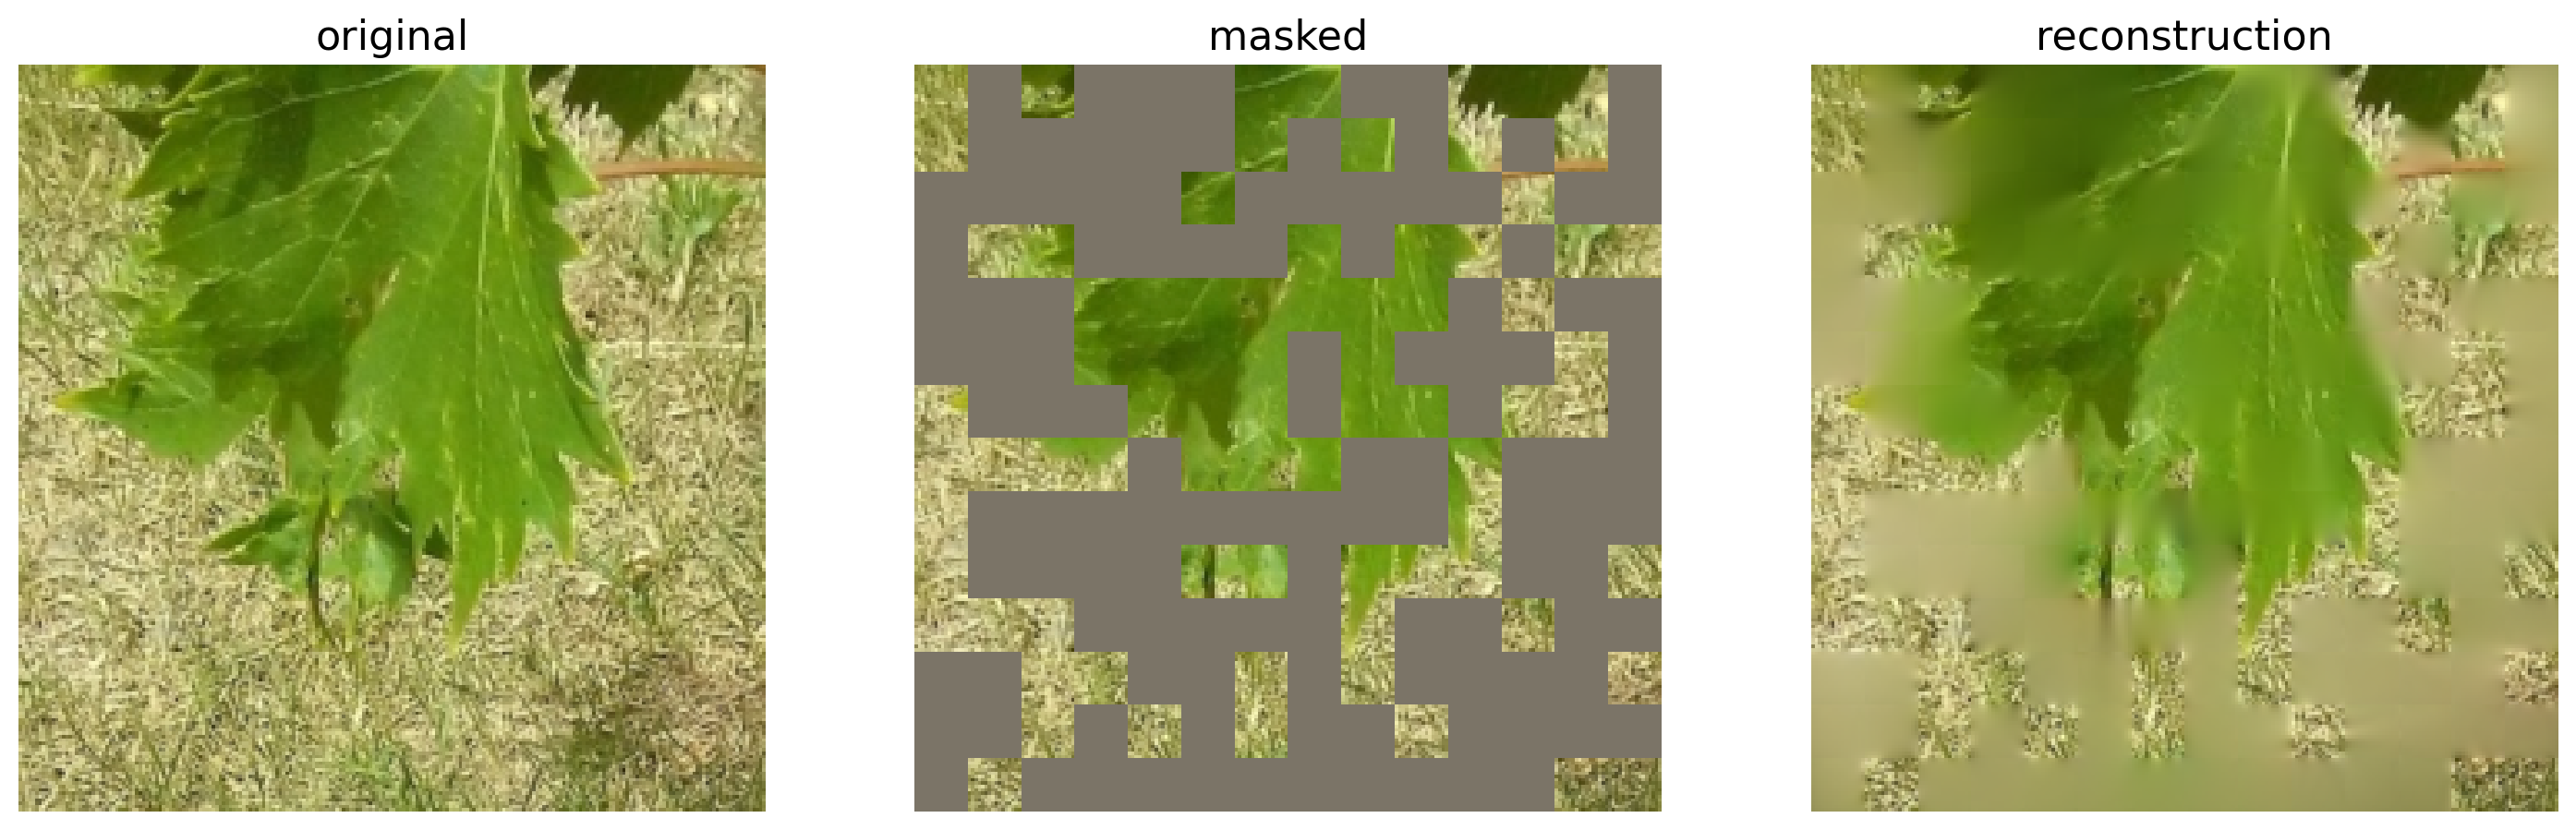

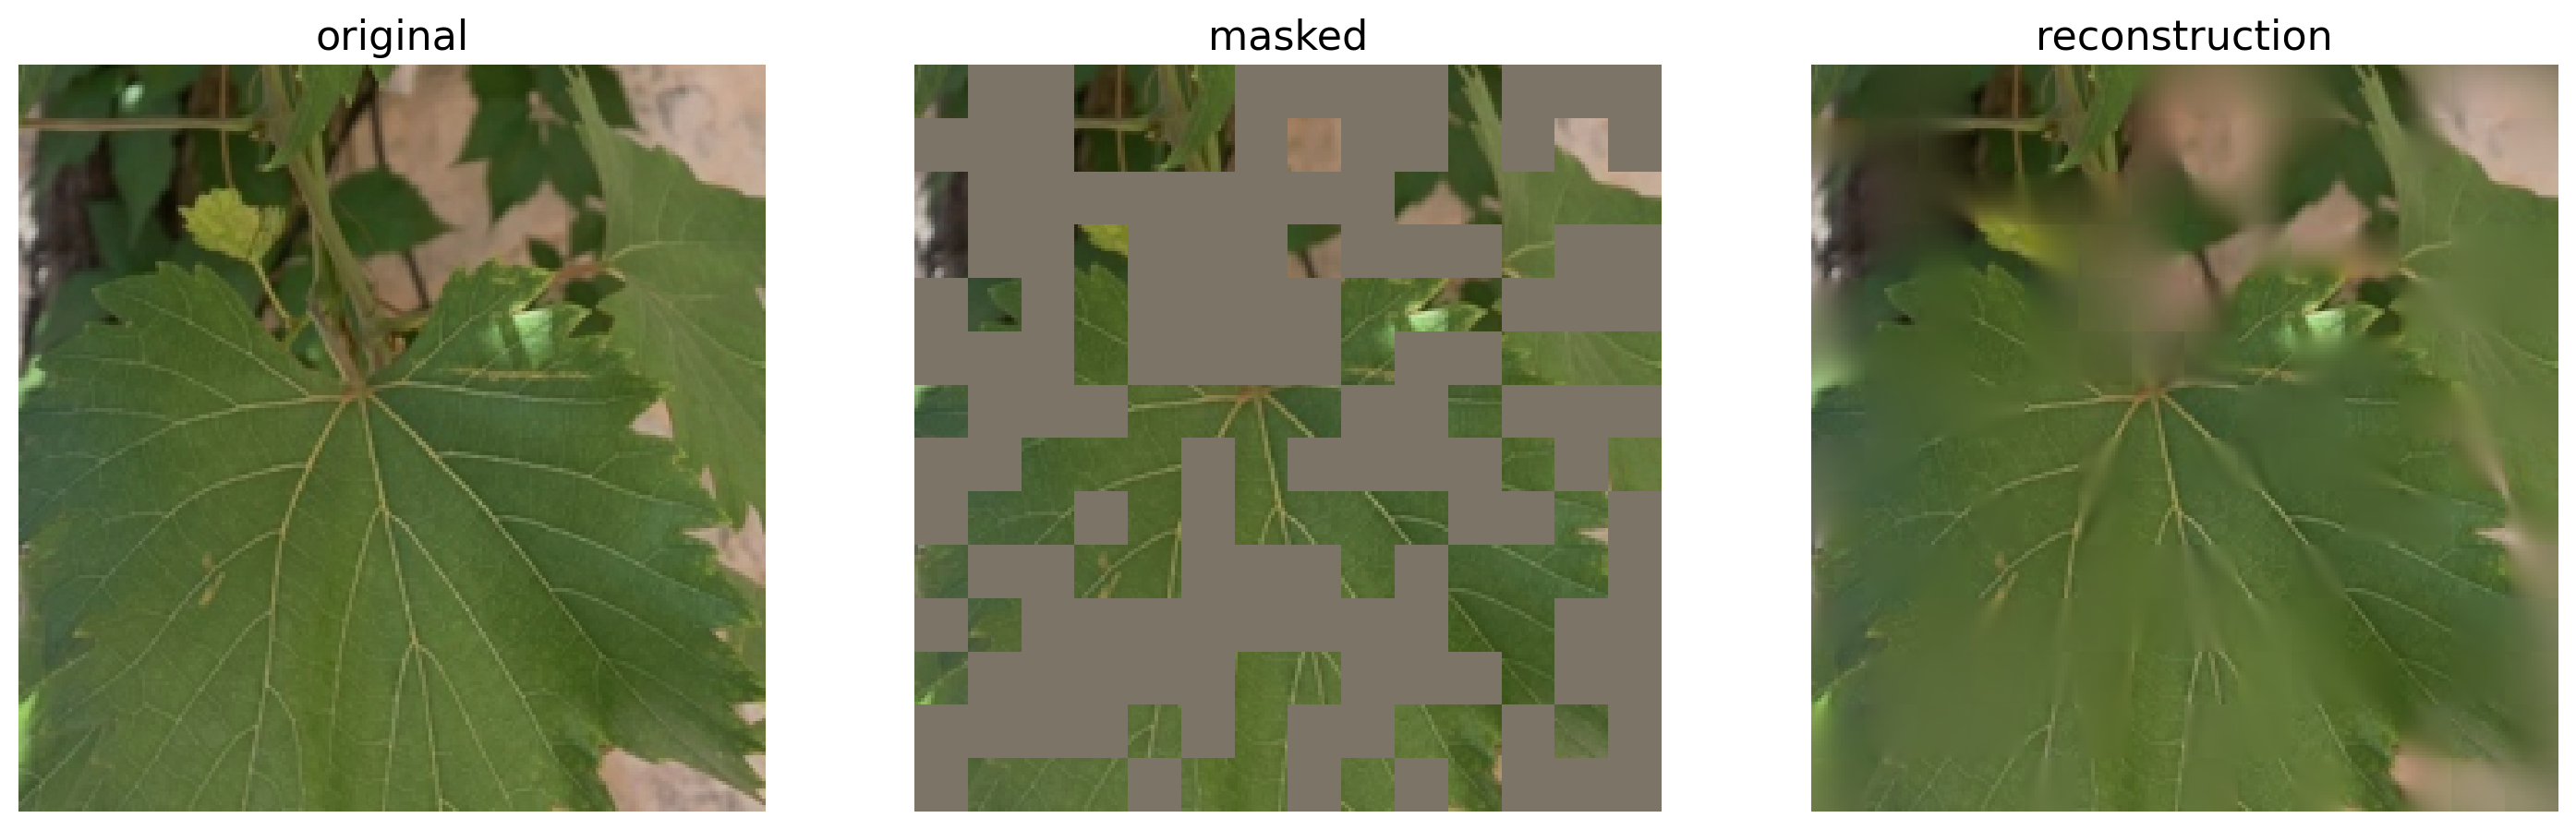

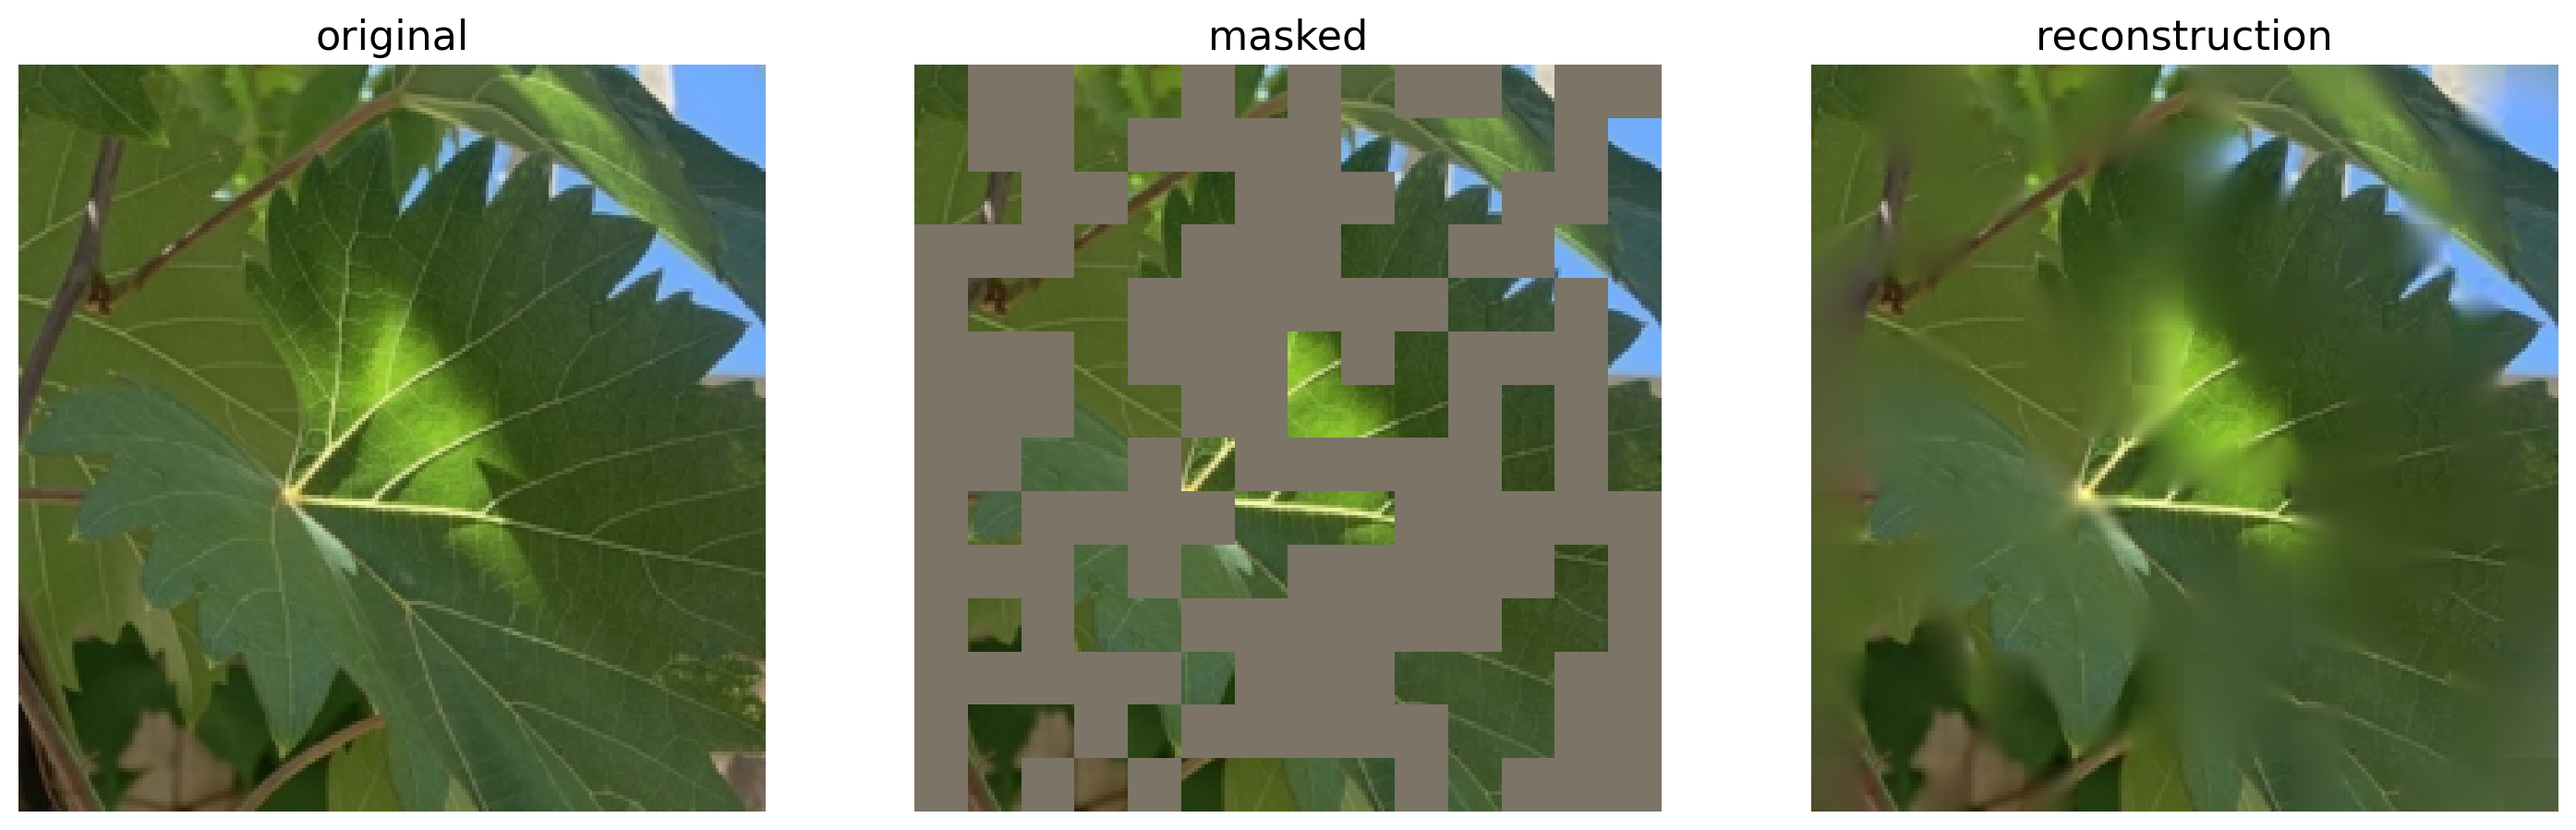

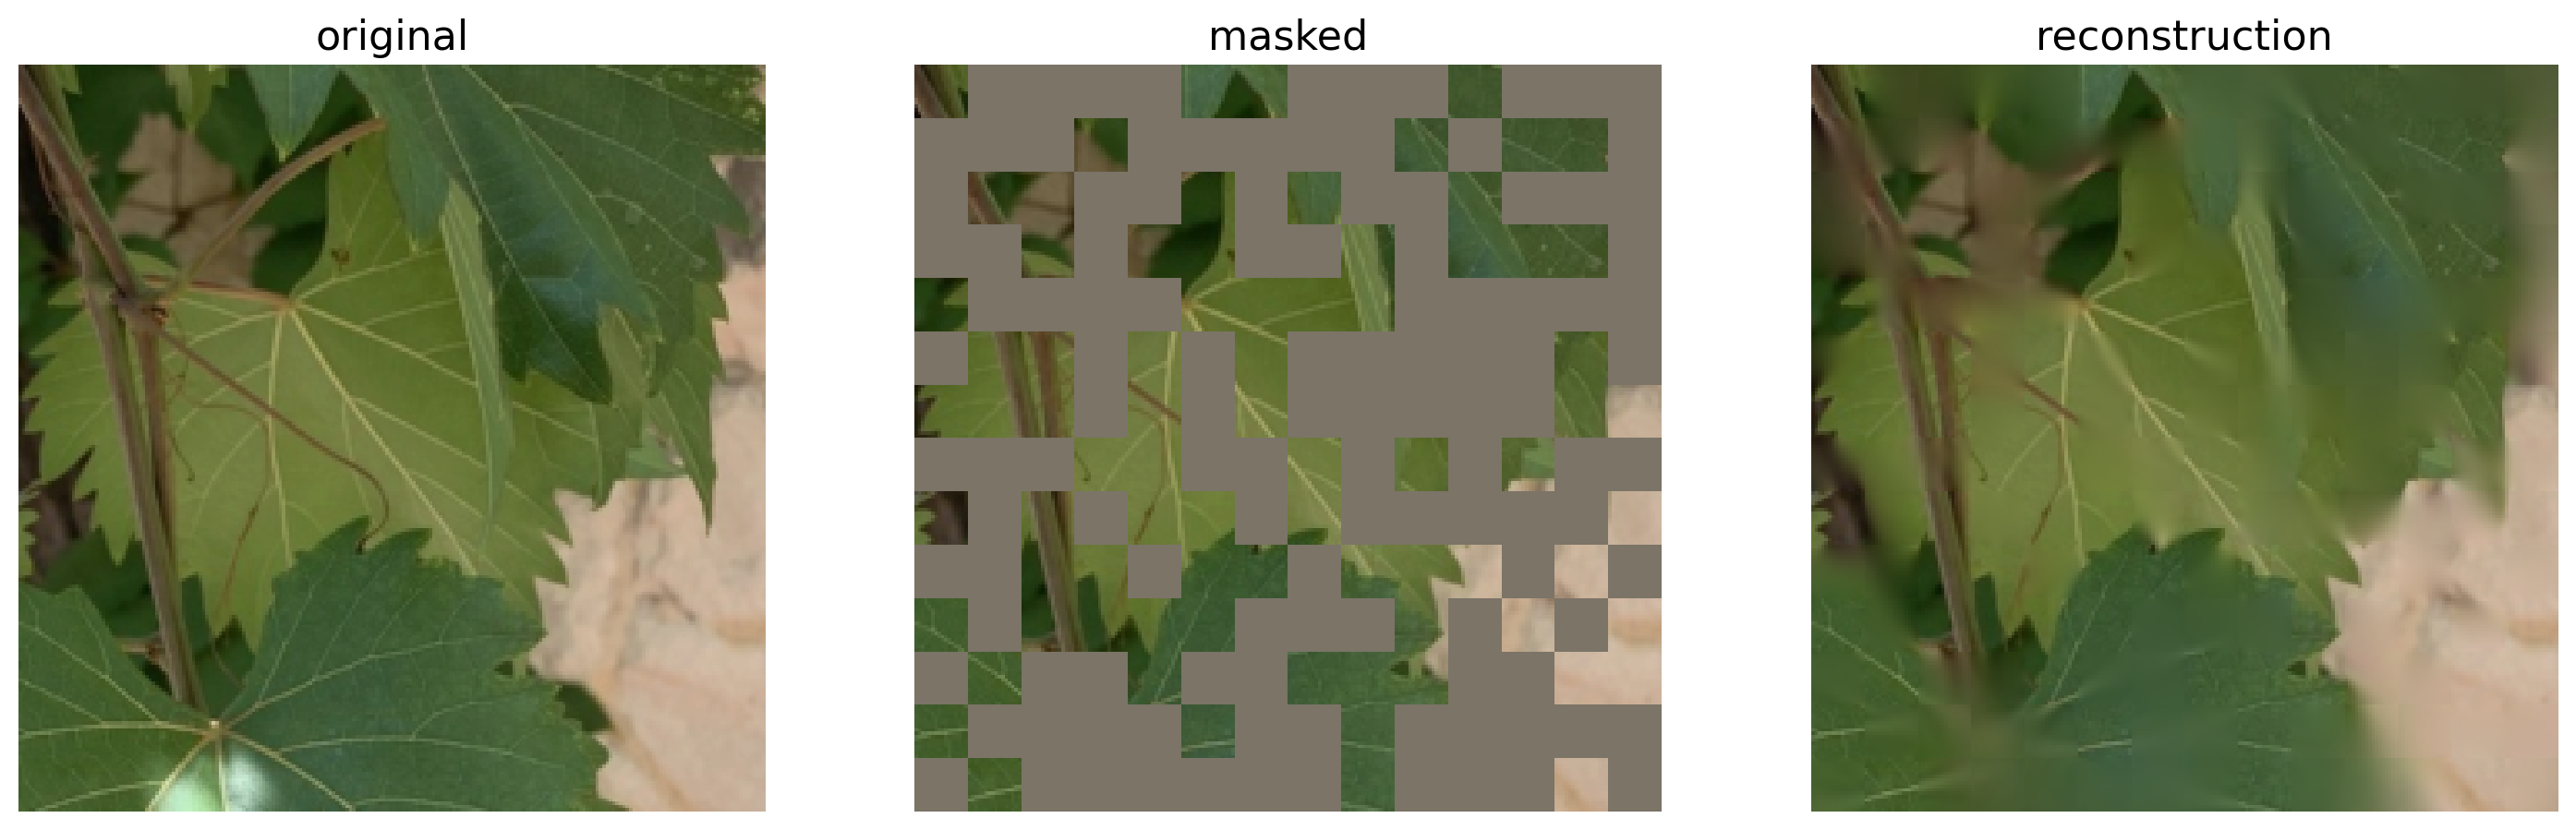

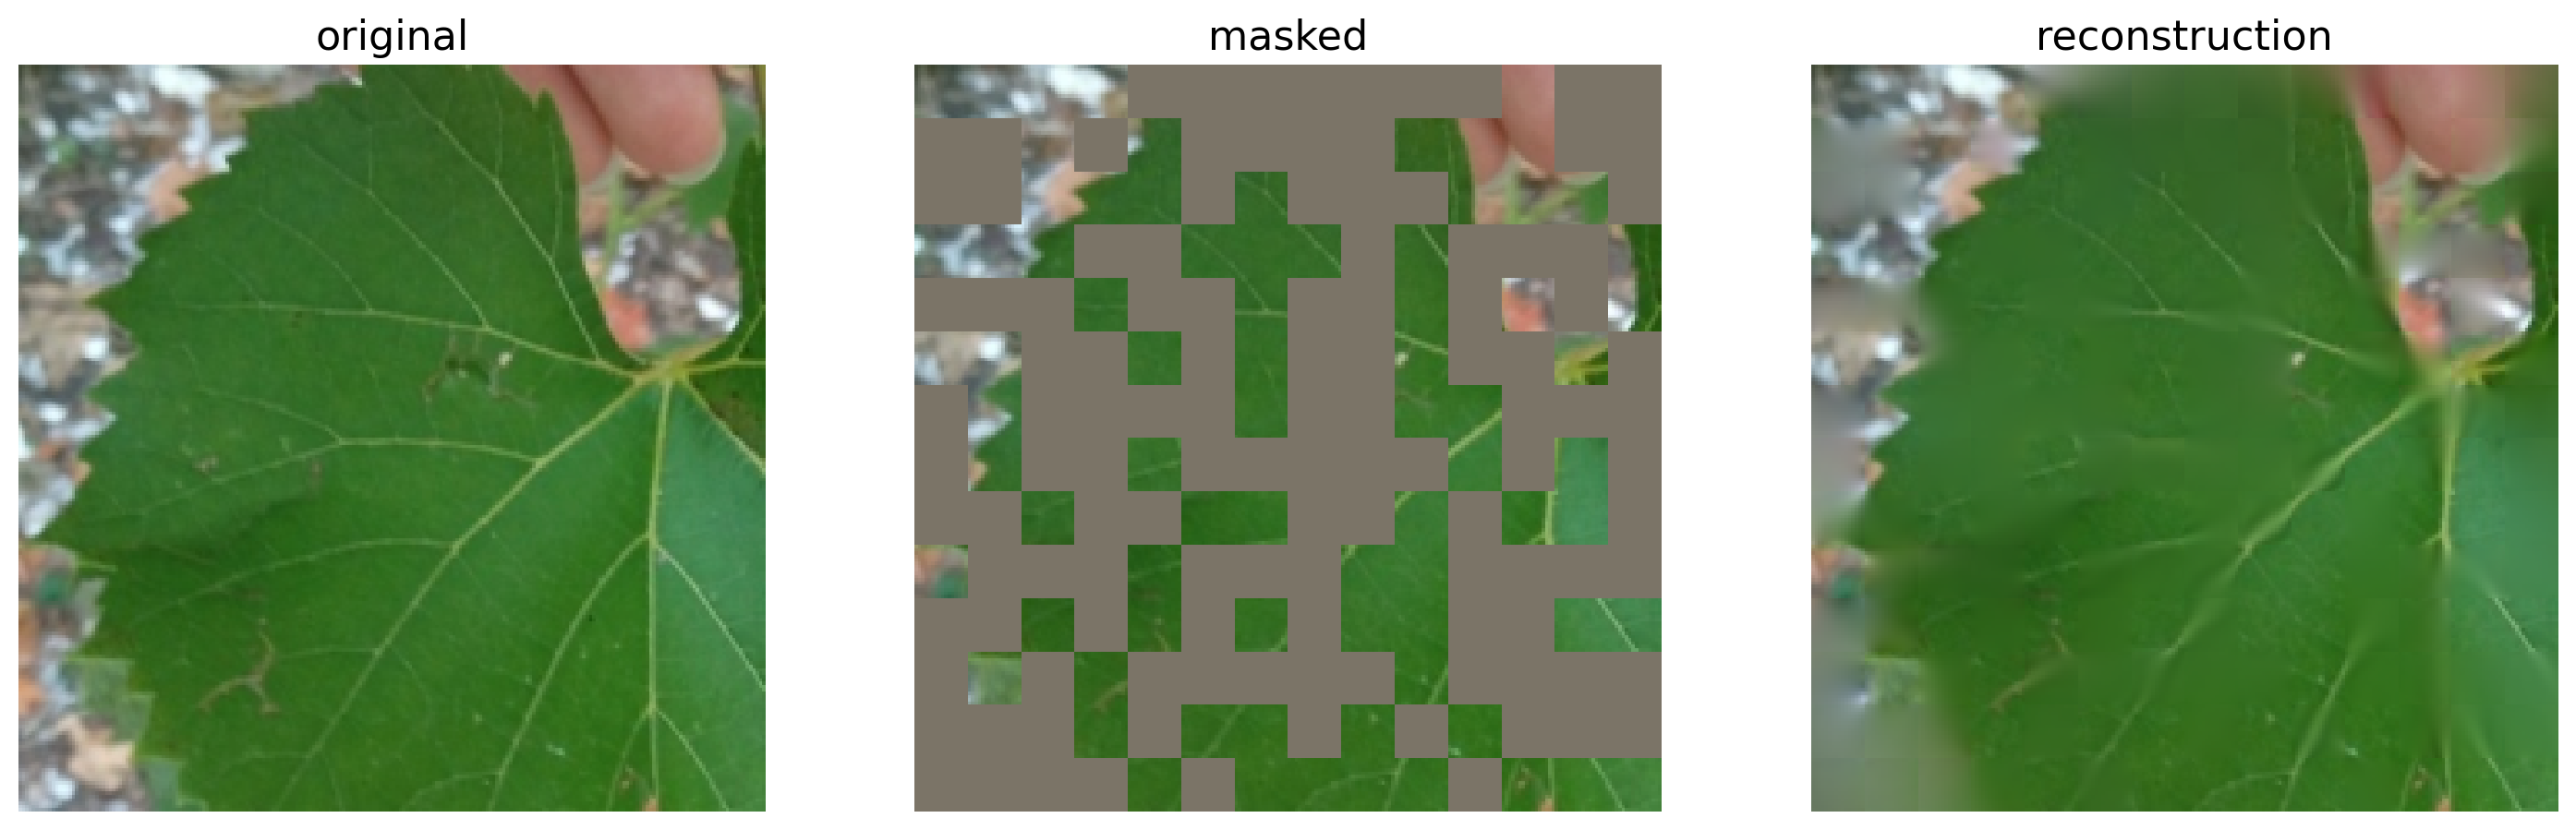

In [164]:
#vit = models.vit_b_32(weights=models.ViT_B_32_Weights.IMAGENET1K_V1)
vit = models.vit_b_16(weights=None)
model = MAE(vit)
model.load_state_dict(torch.load(path_mae), strict=False)

#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
model.to(device)


model.eval()
total_loss = 0.0
mask_token = nn.Parameter(torch.zeros(1, 1, model.backbone.hidden_dim))
for batch in test_ds:
    views = batch[0]
    images = views.to(device)
    predictions, targets, idx_keep, idx_mask = model(images)

    
    patches = utils.patchify(images, model.patch_size)

    x_masked = utils.repeat_token(
        mask_token, (images.shape[0], model.sequence_length-1)
    )

    idx_keep = idx_keep[:,1:]-1
    idx_mask = idx_mask-1

    idx_keep, _ = torch.sort(idx_keep, -1)

    patches_to_keep = utils.get_at_index(patches, idx_keep)
    x_masked = utils.set_at_index(x_masked, idx_keep, patches_to_keep.type_as(x_masked))

    images_masked = unpatchify(x_masked.detach().cpu(), model.patch_size)
    #print(patchified.shape)

    x_masked = utils.repeat_token(
        mask_token, (images.shape[0], model.sequence_length-1)
    )
    x_masked = utils.set_at_index(x_masked, idx_keep, patches_to_keep.type_as(x_masked))
    x_masked = utils.set_at_index(x_masked, idx_mask, predictions.type_as(x_masked))
    reconstructed = unpatchify(x_masked.detach().cpu(), model.patch_size)

    
    for k in range(images.shape[0]):
        # make the plt figure larger
        plt.rcParams['figure.figsize'] = [24, 24]
    
        plt.subplot(1, 4, 1)
        show_image(images[k], "original")
    
        plt.subplot(1, 4, 2)
        show_image(images_masked[k], "masked")
    
        plt.subplot(1, 4, 3)
        show_image(reconstructed[k], "reconstruction")

        plt.show()
    
    break


In [ ]:
model.load_state_dict(torch.load(path_weight), strict=False)
path_weight_encoder = os.path.join(os.path.join(path_models, 'models'), 'encoder' + weight_save_name)
#vit.encoder = model.backbone.encoder
torch.save(model.backbone.state_dict(), path_weight_encoder)


In [ ]:
import utils
import importlib
importlib.reload(utils)
#classes.sort()
mlflow_activate = True

#lr = 1e-3

#model.load_state_dict(torch.load(path_weight_ft), strict=False)

#report = utils.confusion_matrix(test_ds, model, class_labels=[classes_alias[c.lower()] for c in classes],mode='pytorch', sns=True, normalize=True)

import mlflow
if mlflow_activate:
    with mlflow.start_run():
        mlflow.set_experiment(experiment_description)
        mlflow.log_param("batch_size", 12)
        mlflow.log_param("dim", IMG_SIZE)
        mlflow.log_param("dataset", main_path.split(os.path.sep)[-1])
        mlflow.log_param("optimizer", 'AdamW')
        mlflow.log_param("lr", lr)
        mlflow.log_artifact(path_weight)
        #mlflow.log_text(report, F"ft_{model_save_name}_cm.txt")
        #mlflow.log_figure(plt.gcf(), 'cm.png')
        mlflow.log_param("loss", 'MAE')
        mlflow.log_param("comments", comments or '')
        mlflow.end_run()

In [ ]:
model.backbone